## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [1]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-09-30 13:37:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.008s  

2022-09-30 13:37:55 (8.86 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [2]:
import pandas as pd
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [12]:
from sklearn.model_selection import train_test_split

df['target'] = df['card'].map({'yes': 1, 'no': 0})

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(791, 264, 264)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [34]:
from sklearn.metrics import roc_auc_score

variables = ['reports', 'dependents', 'active', 'share']

scores = dict()

for v in variables:
    auc = roc_auc_score(y_train, df_train[v])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])
        
    scores[v] = auc
    
    
pd.Series(scores, name='AUC').sort_values(ascending=False)
    


share         0.989184
reports       0.716663
active        0.604317
dependents    0.532776
Name: AUC, dtype: float64

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [44]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [45]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred_val = model.predict(X_val)
roc_auc_score(y_val, y_pred_val)

0.9739783600107306

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

Text(0.5, 0, 'Threshold')

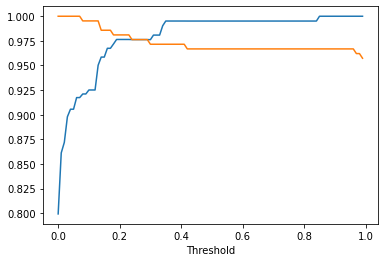

In [67]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

threshold = np.arange(0, 1, 0.01)

precision = []
recall = []

for t in threshold:
    y_proba_pred = model.predict_proba(X_val)[:,1]
    y_pred = (y_proba_pred > t).astype(int)
    
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    

plt.plot(threshold, precision, label='Precision')
plt.plot(threshold, recall, label='Recall')
plt.xlabel('Threshold')

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

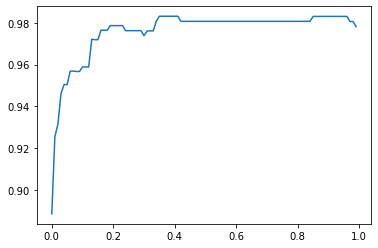

In [70]:
from sklearn.metrics import f1_score

f1 = []

for t in threshold:
    y_proba_pred = model.predict_proba(X_val)[:,1]
    y_pred = (y_proba_pred > t).astype(int)
    
    f1.append(f1_score(y_val, y_pred))
    
plt.plot(threshold, f1)

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [81]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train[features]):
    fold_df_train = df_full_train[features].iloc[train_idx]
    fold_train_y = df_full_train['target'].iloc[train_idx]
    
    
    fold_df_val = df_full_train[features].iloc[val_idx]
    fold_val_y = df_full_train['target'].iloc[val_idx]
    
    
    dv = DictVectorizer(sparse=False)

    train_dict = fold_df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, fold_train_y)
    
    
    val_dict = fold_df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred_val = model.predict(X_val)
    
    
    scores.append(roc_auc_score(fold_val_y, y_pred_val))
    
pd.Series(scores).describe()

count    5.000000
mean     0.983349
std      0.012965
min      0.967539
25%      0.973979
50%      0.984375
75%      0.990854
max      1.000000
dtype: float64

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [89]:
C_options = [0.01, 0.1, 1, 10]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

cv_results = dict()

for c in C_options:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train[features]):
        fold_df_train = df_full_train[features].iloc[train_idx]
        fold_train_y = df_full_train['target'].iloc[train_idx]


        fold_df_val = df_full_train[features].iloc[val_idx]
        fold_val_y = df_full_train['target'].iloc[val_idx]


        dv = DictVectorizer(sparse=False)

        train_dict = fold_df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, fold_train_y)


        val_dict = fold_df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        y_pred_val = model.predict(X_val)


        scores.append(roc_auc_score(fold_val_y, y_pred_val))
        
        
    scores = pd.Series(scores)
    cv_results[c] = dict(mean=scores.mean(), std=scores.std())

In [91]:
pd.DataFrame(cv_results).T.sort_values(['mean', 'std'], ascending=False)

,mean,std
0.01,0.986629,0.007309
0.10,0.984928,0.011001
1.00,0.983349,0.012965
10.00,0.977740,0.016042


## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.